<a href="https://colab.research.google.com/github/manojmanivannan/ApacheSparkEssentials/blob/master/ML_SparkByPluralsight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [5]:
# !apt-get update
# !apt-get install -y openjdk-8-jdk-headless scala jq  > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
# !tar xf spark-2.3.1-bin-hadoop2.7.tgz
# !wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip
# !pip install -q pyspark findspark


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now
Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 60.1 MB/s 


In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [7]:
!python --version

Python 3.8.15


In [8]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

# Spark session & context
conf = SparkConf().set('spark.ui.port', '4050')
try:
  sc = SparkContext(conf=conf)
except ValueError:
  sc.stop()
  sc = SparkContext(conf=conf)

spark = SparkSession.builder.master('local[2]').getOrCreate()

In [9]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [10]:
# create new token from ngrok
get_ipython().system_raw('./ngrok authtoken 2Icy8FQ3TBbFTdCf8HdmTNg2Gna_7HwR9ytuwftMCCyeNoS4n')
# revoke the token once you close the notebook
get_ipython().system_raw('./ngrok http 4050 &')

In [11]:
!sleep 10 && curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://facb-35-245-208-184.ngrok.io


In [12]:
# Dataset
# https://goo.gl/pSKLMJ or https://archive.ics.uci.edu/ml/datasets/wine


In [13]:
rawData = sc.textFile('wine.data')

In [15]:
rawData.take(5)

['1,14.23,1.71,2.43,15.6,127,2.8,3.06,.28,2.29,5.64,1.04,3.92,1065',
 '1,13.2,1.78,2.14,11.2,100,2.65,2.76,.26,1.28,4.38,1.05,3.4,1050',
 '1,13.16,2.36,2.67,18.6,101,2.8,3.24,.3,2.81,5.68,1.03,3.17,1185',
 '1,14.37,1.95,2.5,16.8,113,3.85,3.49,.24,2.18,7.8,.86,3.45,1480',
 '1,13.24,2.59,2.87,21,118,2.8,2.69,.39,1.82,4.32,1.04,2.93,735']

In [16]:
# Column # 
# 0) - Wine maker 1,2 or 3
# 1) Alcohol
# 2) Malic acid
# 3) Ash
# 4) Alcalinity of ash
# 5) Magnesium
# 6) Total phenols
# 7) Flavanoids
# 8) Nonflavanoid phenols
# 9) Proanthocyanins
# 10)Color intensity
# 11)Hue
# 12)OD280/OD315 of diluted wines
# 13)Proline

# Using the older Spark mllib library

In [17]:
from pyspark.mllib.regression import LabeledPoint

def parsePoint(line):
  values = [float(x) for x in line.split(',')]
  return LabeledPoint(values[0],values[1:])


In [18]:
parsedData = rawData.map(parsePoint)
parsedData.take(5)

[LabeledPoint(1.0, [14.23,1.71,2.43,15.6,127.0,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065.0]),
 LabeledPoint(1.0, [13.2,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050.0]),
 LabeledPoint(1.0, [13.16,2.36,2.67,18.6,101.0,2.8,3.24,0.3,2.81,5.68,1.03,3.17,1185.0]),
 LabeledPoint(1.0, [14.37,1.95,2.5,16.8,113.0,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480.0]),
 LabeledPoint(1.0, [13.24,2.59,2.87,21.0,118.0,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735.0])]

In [19]:
(trainingData, testData) = parsedData.randomSplit([0.7,0.3])

In [20]:
from pyspark.mllib.tree import DecisionTree

model = DecisionTree.trainClassifier(trainingData,
                                     numClasses=4, # there are classes 1,2,3 as wine makers , so should 1+greatest value
                                     categoricalFeaturesInfo={},
                                     impurity='gini',
                                     maxDepth=3,
                                     maxBins=32)

In [21]:
predictions = model.predict(testData.map(lambda x: x.features))
predictions.take(5)

[1.0, 1.0, 2.0, 2.0, 1.0]

In [22]:
# compare predictions with actual labels
labelsAndPredictions = testData.map(lambda x: x.label).zip(predictions)
labelsAndPredictions.take(5)

[(1.0, 1.0), (1.0, 1.0), (1.0, 2.0), (1.0, 2.0), (1.0, 1.0)]

In [23]:
testAcc = labelsAndPredictions\
                .filter(lambda x: x[0] == x[1])\
                .count() / float(testData.count())
print('Test Accuracy = ', testAcc)                

Test Accuracy =  0.8


In [24]:
# we have a built-in function for evaluating metrics
from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(labelsAndPredictions)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [25]:
metrics.accuracy

0.8

In [26]:
metrics.precision(1.0)

0.5714285714285714

In [27]:
metrics.precision(3.0)

1.0

In [28]:
metrics.confusionMatrix().toArray()

array([[ 8.,  0.,  0.],
       [ 5., 20.,  0.],
       [ 1.,  3.,  8.]])

In [29]:
# to view the decision tree
print(model.toDebugString())

DecisionTreeModel classifier of depth 3 with 11 nodes
  If (feature 12 <= 961.0)
   If (feature 6 <= 1.2650000000000001)
    If (feature 9 <= 3.065)
     Predict: 2.0
    Else (feature 9 > 3.065)
     Predict: 3.0
   Else (feature 6 > 1.2650000000000001)
    If (feature 9 <= 6.05)
     Predict: 2.0
    Else (feature 9 > 6.05)
     Predict: 3.0
  Else (feature 12 > 961.0)
   If (feature 0 <= 13.01)
    Predict: 2.0
   Else (feature 0 > 13.01)
    Predict: 1.0



# LIBSVM data format

Each row in a dataset, has a label and features.
Features are referred as index.
i.e, index1 => feature1
so a record is represented as

| label | index1:value1 | index2:value2 | index3:value3 | ... |
|-------|---------------|---------------|---------------|-----|
| 0     | 1:324         | 2:332         | 3:12          | ... |
| 1     | 1:455         | 2:213         | 3:85          | ... |
| 0     | 1:344         | 2:165         |               | ... |

missing feature can be represented by simply omitting them.


In [30]:
from pyspark.mllib.util import MLUtils
# dataset https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/wine.scale
libsvmData = MLUtils.loadLibSVMFile(sc, 'wine.scale')

In [31]:
libsvmData.take(5)

[LabeledPoint(1.0, (13,[0,1,2,3,4,5,6,7,8,9,10,11,12],[0.68421,-0.616601,0.144385,-0.484536,0.23913,0.255172,0.147679,-0.433962,0.18612,-0.255973,-0.089431,0.941392,0.122682])),
 LabeledPoint(1.0, (13,[0,1,2,3,4,5,6,7,8,9,10,11,12],[0.142105,-0.588933,-0.165775,-0.938144,-0.347826,0.151724,0.0210971,-0.509434,-0.451104,-0.47099,-0.0731708,0.56044,0.101284])),
 LabeledPoint(1.0, (13,[0,1,2,3,4,5,6,7,8,9,10,11,12],[0.121053,-0.359684,0.40107,-0.175258,-0.326087,0.255172,0.223629,-0.358491,0.514196,-0.249147,-0.105691,0.391941,0.293866])),
 LabeledPoint(1.0, (13,[0,1,2,3,4,5,6,7,8,9,10,11,12],[0.757895,-0.521739,0.219251,-0.360825,-0.0652174,0.97931,0.329114,-0.584906,0.116719,0.112628,-0.382114,0.59707,0.714693])),
 LabeledPoint(1.0, (13,[0,1,2,3,4,5,6,7,8,9,10,11,12],[0.163158,-0.268775,0.614973,0.0721649,0.0434783,0.255172,-0.00843878,-0.018868,-0.11041,-0.481229,-0.089431,0.216117,-0.348074]))]

In [32]:
(trainingData, testData) = libsvmData.randomSplit([0.8,0.2])

In [33]:
libsvmmodel = DecisionTree.trainClassifier(trainingData,
                                     numClasses=4, # there are classes 1,2,3 as wine makers , so should 1+greatest value
                                     categoricalFeaturesInfo={},
                                     impurity='gini',
                                     maxDepth=5,
                                     maxBins=32)

In [34]:
predictions = libsvmmodel.predict(testData.map(lambda x: x.features))

In [35]:
labelsAndPredictions = testData.map(lambda x: x.label).zip(predictions)
labelsAndPredictions.take(5)

[(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0)]

In [36]:
metrics = MulticlassMetrics(labelsAndPredictions)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [37]:
metrics.accuracy

0.8717948717948718

In [38]:
metrics.confusionMatrix().toArray()

array([[10.,  1.,  0.],
       [ 0., 12.,  4.],
       [ 0.,  0., 12.]])

In [39]:
print(model.toDebugString())

DecisionTreeModel classifier of depth 3 with 11 nodes
  If (feature 12 <= 961.0)
   If (feature 6 <= 1.2650000000000001)
    If (feature 9 <= 3.065)
     Predict: 2.0
    Else (feature 9 > 3.065)
     Predict: 3.0
   Else (feature 6 > 1.2650000000000001)
    If (feature 9 <= 6.05)
     Predict: 2.0
    Else (feature 9 > 6.05)
     Predict: 3.0
  Else (feature 12 > 961.0)
   If (feature 0 <= 13.01)
    Predict: 2.0
   Else (feature 0 > 13.01)
    Predict: 1.0



# Using the newer Spark ml library

In [40]:
 rawData = spark.read\
                .format('csv')\
                .option('header','false')\
                .load('wine.data')

In [41]:
rawData

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string]

In [42]:
rawData.show(5)

+---+-----+----+----+----+---+----+----+---+----+----+----+----+----+
|_c0|  _c1| _c2| _c3| _c4|_c5| _c6| _c7|_c8| _c9|_c10|_c11|_c12|_c13|
+---+-----+----+----+----+---+----+----+---+----+----+----+----+----+
|  1|14.23|1.71|2.43|15.6|127| 2.8|3.06|.28|2.29|5.64|1.04|3.92|1065|
|  1| 13.2|1.78|2.14|11.2|100|2.65|2.76|.26|1.28|4.38|1.05| 3.4|1050|
|  1|13.16|2.36|2.67|18.6|101| 2.8|3.24| .3|2.81|5.68|1.03|3.17|1185|
|  1|14.37|1.95| 2.5|16.8|113|3.85|3.49|.24|2.18| 7.8| .86|3.45|1480|
|  1|13.24|2.59|2.87|  21|118| 2.8|2.69|.39|1.82|4.32|1.04|2.93| 735|
+---+-----+----+----+----+---+----+----+---+----+----+----+----+----+
only showing top 5 rows



In [43]:
dataset = rawData.toDF('Label',
                      'Alcohol',
                      'MalicAcid',
                      'Ash',
                      'AshAlkalinity',
                      'Magnesium',
                      'TotalPhenols',
                      'Flavanoids',
                      'NonflavanoidPhenols',
                      'Proanthocyanin',
                      'ColorIntensity',
                      'Hue',
                      'OD',
                      'Proline')

In [44]:
dataset

DataFrame[Label: string, Alcohol: string, MalicAcid: string, Ash: string, AshAlkalinity: string, Magnesium: string, TotalPhenols: string, Flavanoids: string, NonflavanoidPhenols: string, Proanthocyanin: string, ColorIntensity: string, Hue: string, OD: string, Proline: string]

In [45]:
dataset.show(5)

+-----+-------+---------+----+-------------+---------+------------+----------+-------------------+--------------+--------------+----+----+-------+
|Label|Alcohol|MalicAcid| Ash|AshAlkalinity|Magnesium|TotalPhenols|Flavanoids|NonflavanoidPhenols|Proanthocyanin|ColorIntensity| Hue|  OD|Proline|
+-----+-------+---------+----+-------------+---------+------------+----------+-------------------+--------------+--------------+----+----+-------+
|    1|  14.23|     1.71|2.43|         15.6|      127|         2.8|      3.06|                .28|          2.29|          5.64|1.04|3.92|   1065|
|    1|   13.2|     1.78|2.14|         11.2|      100|        2.65|      2.76|                .26|          1.28|          4.38|1.05| 3.4|   1050|
|    1|  13.16|     2.36|2.67|         18.6|      101|         2.8|      3.24|                 .3|          2.81|          5.68|1.03|3.17|   1185|
|    1|  14.37|     1.95| 2.5|         16.8|      113|        3.85|      3.49|                .24|          2.18|     

In [46]:
from pyspark.ml.linalg import Vectors

def vectorize(data):
  return data.rdd.map(lambda r: [r[0], Vectors.dense(r[1:])]).toDF(['label','features'])
  

In [47]:
vectorizedData = vectorize(dataset)

In [48]:
vectorizedData.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[14.23,1.71,2.43,...|
|    1|[13.2,1.78,2.14,1...|
|    1|[13.16,2.36,2.67,...|
|    1|[14.37,1.95,2.5,1...|
|    1|[13.24,2.59,2.87,...|
+-----+--------------------+
only showing top 5 rows



In [49]:
vectorizedData.take(5)

[Row(label='1', features=DenseVector([14.23, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0])),
 Row(label='1', features=DenseVector([13.2, 1.78, 2.14, 11.2, 100.0, 2.65, 2.76, 0.26, 1.28, 4.38, 1.05, 3.4, 1050.0])),
 Row(label='1', features=DenseVector([13.16, 2.36, 2.67, 18.6, 101.0, 2.8, 3.24, 0.3, 2.81, 5.68, 1.03, 3.17, 1185.0])),
 Row(label='1', features=DenseVector([14.37, 1.95, 2.5, 16.8, 113.0, 3.85, 3.49, 0.24, 2.18, 7.8, 0.86, 3.45, 1480.0])),
 Row(label='1', features=DenseVector([13.24, 2.59, 2.87, 21.0, 118.0, 2.8, 2.69, 0.39, 1.82, 4.32, 1.04, 2.93, 735.0]))]

In [50]:
from pyspark.ml.feature import StringIndexer

labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel')

In [51]:
indexedData = labelIndexer.fit(vectorizedData).transform(vectorizedData)
indexedData.take(2)

[Row(label='1', features=DenseVector([14.23, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0]), indexedLabel=1.0),
 Row(label='1', features=DenseVector([13.2, 1.78, 2.14, 11.2, 100.0, 2.65, 2.76, 0.26, 1.28, 4.38, 1.05, 3.4, 1050.0]), indexedLabel=1.0)]

In [52]:
indexedData

DataFrame[label: string, features: vector, indexedLabel: double]

In [53]:
indexedData.select('label').distinct().show()

+-----+
|label|
+-----+
|    3|
|    1|
|    2|
+-----+



In [54]:
indexedData.select('indexedLabel').distinct().show()

+------------+
|indexedLabel|
+------------+
|         0.0|
|         1.0|
|         2.0|
+------------+



In [55]:
(trainingData, testData) = indexedData.randomSplit([0.8,0.2])

In [56]:
from pyspark.ml.classification import DecisionTreeClassifier

dtree = DecisionTreeClassifier(
    labelCol='indexedLabel',
    featuresCol='features',
    maxDepth=3,
    impurity='gini'
)

In [57]:
model = dtree.fit(trainingData)

In [58]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',
                                              predictionCol='prediction',
                                              metricName='f1')

In [59]:
transformed_data = model.transform(testData)
transformed_data.show(5,truncate=False)

+-----+---------------------------------------------------------------------+------------+--------------+---------------------------------------------+----------+
|label|features                                                             |indexedLabel|rawPrediction |probability                                  |prediction|
+-----+---------------------------------------------------------------------+------------+--------------+---------------------------------------------+----------+
|1    |[13.16,2.36,2.67,18.6,101.0,2.8,3.24,0.3,2.81,5.68,1.03,3.17,1185.0] |1.0         |[0.0,45.0,0.0]|[0.0,1.0,0.0]                                |1.0       |
|1    |[13.24,2.59,2.87,21.0,118.0,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735.0] |1.0         |[43.0,2.0,0.0]|[0.9555555555555556,0.044444444444444446,0.0]|0.0       |
|1    |[13.39,1.77,2.62,16.1,93.0,2.85,2.94,0.34,1.45,4.8,0.92,3.22,1195.0] |1.0         |[0.0,45.0,0.0]|[0.0,1.0,0.0]                                |1.0       |
|1    |[13.51,1.8,2.65

In [60]:
print(evaluator.getMetricName(),
      'accuracy: ',
      evaluator.evaluate(transformed_data))

f1 accuracy:  0.883798708874543


# Random Forest ML

In [61]:
rawData = spark.read\
                .format('csv')\
                .option('header','false')\
                .option('ignoreLeadingWhiteSpace','true')\
                .load('adult.csv')

In [62]:
dataset = rawData.toDF('Age',
                       'WorkClass',
                       'FnlWgt',
                       'Education',
                       'EducationNum',
                       'MaritalStatus',
                       'Occupation',
                       'Relationship',
                       'Race',
                       'Gender',
                       'CapitalGain',
                       'CapitalLoss',
                       'HoursPerWeek',
                       'NativeCountry',
                       'Label')

In [63]:
dataset.take(5)

[Row(Age='39', WorkClass='State-gov', FnlWgt='77516', Education='Bachelors', EducationNum='13', MaritalStatus='Never-married', Occupation='Adm-clerical', Relationship='Not-in-family', Race='White', Gender='Male', CapitalGain='2174', CapitalLoss='0', HoursPerWeek='40', NativeCountry='United-States', Label='<=50K'),
 Row(Age='50', WorkClass='Self-emp-not-inc', FnlWgt='83311', Education='Bachelors', EducationNum='13', MaritalStatus='Married-civ-spouse', Occupation='Exec-managerial', Relationship='Husband', Race='White', Gender='Male', CapitalGain='0', CapitalLoss='0', HoursPerWeek='13', NativeCountry='United-States', Label='<=50K'),
 Row(Age='38', WorkClass='Private', FnlWgt='215646', Education='HS-grad', EducationNum='9', MaritalStatus='Divorced', Occupation='Handlers-cleaners', Relationship='Not-in-family', Race='White', Gender='Male', CapitalGain='0', CapitalLoss='0', HoursPerWeek='40', NativeCountry='United-States', Label='<=50K'),
 Row(Age='53', WorkClass='Private', FnlWgt='234721', 

In [64]:
dataset.toPandas().head()

,Age,WorkClass,FnlWgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [65]:
dataset = dataset.drop('FnlWgt')
dataset = dataset.replace('?',None)
dataset.count()


32561

In [66]:
dataset = dataset.dropna(how='any')
dataset.count()

30162

In [67]:
dataset.describe()

DataFrame[summary: string, Age: string, WorkClass: string, Education: string, EducationNum: string, MaritalStatus: string, Occupation: string, Relationship: string, Race: string, Gender: string, CapitalGain: string, CapitalLoss: string, HoursPerWeek: string, NativeCountry: string, Label: string]

In [68]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col

dataset = dataset.withColumn('Age',dataset['Age'].cast(FloatType()))
dataset = dataset.withColumn('EducationNum',dataset['EducationNum'].cast(FloatType()))
dataset = dataset.withColumn('CapitalGain',dataset['CapitalGain'].cast(FloatType()))
dataset = dataset.withColumn('CapitalLoss',dataset['CapitalLoss'].cast(FloatType()))
dataset = dataset.withColumn('HoursPerWeek',dataset['HoursPerWeek'].cast(FloatType()))

In [69]:
dataset.toPandas().head()

,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Label
0,39.0,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [70]:
indexedDF = StringIndexer(inputCol='WorkClass', outputCol='WorkClass_index').fit(dataset).transform(dataset)


In [71]:
indexedDF.toPandas().head()

,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Label,WorkClass_index
0,39.0,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,3.0
1,50.0,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,1.0
2,38.0,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,0.0
3,53.0,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,0.0
4,28.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,0.0


In [72]:
from pyspark.ml.feature import OneHotEncoder

encodedDF = OneHotEncoder(
    inputCol="WorkClass_index",
    outputCol="WorkClass_encoded"
).fit(indexedDF).transform(indexedDF)

In [73]:
encodedDF.toPandas().head()

,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Label,WorkClass_index,WorkClass_encoded
0,39.0,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
1,50.0,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
2,38.0,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,53.0,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,28.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [74]:
encodedDF.select('WorkClass','WorkClass_index','WorkClass_encoded').toPandas().head()

,WorkClass,WorkClass_index,WorkClass_encoded
0,State-gov,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
1,Self-emp-not-inc,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
2,Private,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,Private,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,Private,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [75]:
(trainingData,testData) = dataset.randomSplit([0.8,0.2])

In [76]:
categoricalFeatures = [
    'WorkClass',
    'Education',
    'MaritalStatus',
    'Relationship',
    'Race',
    'Gender',
    'NativeCountry',
    'Occupation'
]
indexers = [StringIndexer(inputCol=column, 
                          outputCol=column+'_index',
                          handleInvalid='keep') for column in categoricalFeatures]

In [77]:
encoders = [OneHotEncoder(inputCol=column+'_index',
                          outputCol=column+'_encoded') for column in categoricalFeatures]

In [78]:
labelIndexer = [StringIndexer(inputCol='Label',outputCol='Label_index')]

In [79]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers+encoders+labelIndexer)

In [80]:
transformedDF = pipeline.fit(trainingData).transform(trainingData)

In [81]:
transformedDF.toPandas().head()

,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,...,Occupation_index,WorkClass_encoded,Education_encoded,MaritalStatus_encoded,Relationship_encoded,Race_encoded,Gender_encoded,NativeCountry_encoded,Occupation_encoded,Label_index
0,17.0,Federal-gov,11th,7.0,Never-married,Adm-clerical,Not-in-family,Black,Female,0.0,...,3.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
1,17.0,Local-gov,10th,6.0,Never-married,Other-service,Own-child,White,Female,0.0,...,5.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.0
2,17.0,Local-gov,10th,6.0,Never-married,Protective-serv,Own-child,White,Female,0.0,...,11.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
3,17.0,Local-gov,11th,7.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,...,3.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
4,17.0,Local-gov,11th,7.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,...,3.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0


In [82]:
requiredFeatures =[
    'Age',
    'EducationNum',
    'CapitalGain',
    'CapitalGain',
    'HoursPerWeek',
    'WorkClass_encoded',
    'Education_encoded',
    'MaritalStatus_encoded',
    'Occupation_encoded',
    'Relationship_encoded',
    'Race_encoded',
    'Gender_encoded',
    'NativeCountry_encoded'
]

In [83]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

In [84]:
transformedDF = assembler.transform(transformedDF)
transformedDF.toPandas().head()

,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,...,WorkClass_encoded,Education_encoded,MaritalStatus_encoded,Relationship_encoded,Race_encoded,Gender_encoded,NativeCountry_encoded,Occupation_encoded,Label_index,features
0,17.0,Federal-gov,11th,7.0,Never-married,Adm-clerical,Not-in-family,Black,Female,0.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(17.0, 7.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0..."
1,17.0,Local-gov,10th,6.0,Never-married,Other-service,Own-child,White,Female,0.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.0,"(17.0, 6.0, 0.0, 0.0, 25.0, 0.0, 0.0, 1.0, 0.0..."
2,17.0,Local-gov,10th,6.0,Never-married,Protective-serv,Own-child,White,Female,0.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(17.0, 6.0, 0.0, 0.0, 40.0, 0.0, 0.0, 1.0, 0.0..."
3,17.0,Local-gov,11th,7.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(17.0, 7.0, 0.0, 0.0, 12.0, 0.0, 0.0, 1.0, 0.0..."
4,17.0,Local-gov,11th,7.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(17.0, 7.0, 0.0, 0.0, 15.0, 0.0, 0.0, 1.0, 0.0..."


In [85]:
transformedDF.select('features').toPandas().head()

,features
0,"(17.0, 7.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0..."
1,"(17.0, 6.0, 0.0, 0.0, 25.0, 0.0, 0.0, 1.0, 0.0..."
2,"(17.0, 6.0, 0.0, 0.0, 40.0, 0.0, 0.0, 1.0, 0.0..."
3,"(17.0, 7.0, 0.0, 0.0, 12.0, 0.0, 0.0, 1.0, 0.0..."
4,"(17.0, 7.0, 0.0, 0.0, 15.0, 0.0, 0.0, 1.0, 0.0..."


In [86]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='Label_index',
                            featuresCol='features',
                            maxDepth=10)

In [87]:
pipeline = Pipeline(
    stages=indexers+encoders+labelIndexer + [assembler,rf]
)

In [88]:
model = pipeline.fit(trainingData)

In [89]:
predictions = model.transform(testData)
predictionsDF = predictions.toPandas()
predictionsDF.head()

,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,...,Relationship_encoded,Race_encoded,Gender_encoded,NativeCountry_encoded,Occupation_encoded,Label_index,features,rawPrediction,probability,prediction
0,17.0,Local-gov,11th,7.0,Never-married,Craft-repair,Own-child,White,Male,0.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(17.0, 7.0, 0.0, 0.0, 35.0, 0.0, 0.0, 1.0, 0.0...","[19.701719683044693, 0.29828031695530755]","[0.9850859841522347, 0.014914015847765378]",0.0
1,17.0,Local-gov,11th,7.0,Never-married,Prof-specialty,Own-child,White,Female,0.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(17.0, 7.0, 0.0, 0.0, 40.0, 0.0, 0.0, 1.0, 0.0...","[19.607757779892708, 0.39224222010729387]","[0.9803878889946352, 0.01961211100536469]",0.0
2,17.0,Local-gov,9th,5.0,Never-married,Other-service,Own-child,White,Male,0.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.0,"(17.0, 5.0, 0.0, 0.0, 45.0, 0.0, 0.0, 1.0, 0.0...","[19.523996629433004, 0.4760033705669976]","[0.9761998314716502, 0.02380016852834988]",0.0
3,17.0,Private,10th,6.0,Never-married,Handlers-cleaners,Own-child,White,Male,0.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.0,"(17.0, 6.0, 0.0, 0.0, 10.0, 1.0, 0.0, 0.0, 0.0...","[19.628371636015043, 0.3716283639849626]","[0.9814185818007518, 0.01858141819924812]",0.0
4,17.0,Private,10th,6.0,Never-married,Handlers-cleaners,Own-child,White,Male,0.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.0,"(17.0, 6.0, 0.0, 0.0, 20.0, 1.0, 0.0, 0.0, 0.0...","[19.628371636015043, 0.3716283639849626]","[0.9814185818007518, 0.01858141819924812]",0.0


In [90]:
predictions = predictions.select('Label_index','prediction')

In [91]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol='Label_index',
    predictionCol='prediction',
    metricName='accuracy'
)

In [92]:
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy',accuracy)

Test Accuracy 0.8426256077795786


In [93]:
predictionsDF.loc[
    predictionsDF['Label_index'] != predictionsDF['prediction']
]

,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,...,Relationship_encoded,Race_encoded,Gender_encoded,NativeCountry_encoded,Occupation_encoded,Label_index,features,rawPrediction,probability,prediction
222,19.0,Private,HS-grad,9.0,Never-married,Other-service,Own-child,White,Female,34095.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.0,"(19.0, 9.0, 34095.0, 34095.0, 20.0, 1.0, 0.0, ...","[6.980907066546537, 13.019092933453463]","[0.3490453533273269, 0.6509546466726731]",1.0
529,22.0,Local-gov,5th-6th,3.0,Never-married,Handlers-cleaners,Other-relative,White,Male,0.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1.0,"(22.0, 3.0, 0.0, 0.0, 40.0, 0.0, 0.0, 1.0, 0.0...","[19.408410681257802, 0.5915893187422008]","[0.97042053406289, 0.029579465937110035]",0.0
683,23.0,Local-gov,Some-college,10.0,Never-married,Protective-serv,Own-child,White,Male,0.0,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(23.0, 10.0, 0.0, 0.0, 40.0, 0.0, 0.0, 1.0, 0....","[19.464343892617247, 0.5356561073827545]","[0.9732171946308623, 0.026782805369137724]",0.0
714,23.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(23.0, 13.0, 0.0, 0.0, 40.0, 1.0, 0.0, 0.0, 0....","[9.901611311110234, 10.098388688889766]","[0.49508056555551166, 0.5049194344444883]",1.0
715,23.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,0.0,...,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(23.0, 13.0, 0.0, 0.0, 40.0, 1.0, 0.0, 0.0, 0....","[8.70966660535883, 11.290333394641168]","[0.4354833302679415, 0.5645166697320584]",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6118,73.0,Self-emp-not-inc,7th-8th,4.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,6418.0,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(73.0, 4.0, 6418.0, 6418.0, 99.0, 0.0, 1.0, 0....","[14.985752535318644, 5.014247464681358]","[0.7492876267659321, 0.25071237323406786]",0.0
6138,77.0,Local-gov,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Husband,White,Male,3818.0,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(77.0, 13.0, 3818.0, 3818.0, 14.0, 0.0, 0.0, 1...","[6.9399559424951205, 13.06004405750488]","[0.34699779712475604, 0.653002202875244]",1.0
6141,78.0,Local-gov,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(78.0, 13.0, 0.0, 0.0, 15.0, 0.0, 0.0, 1.0, 0....","[7.3217028649111535, 12.678297135088844]","[0.36608514324555774, 0.6339148567544423]",1.0
6149,80.0,Private,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(80.0, 16.0, 0.0, 0.0, 3

# Regression

In [94]:
rawData = spark.read\
                .format('csv')\
                .option('header','true')\
                .load('imports-85.data')

In [96]:
rawData.toPandas().head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8,115,5500,18,22,17450


In [97]:
dataset = rawData.select(col('price').cast('float'),
                         col('make'),
                         col('num-of-doors'),
                         col('body-style'),
                         col('drive-wheels'),
                         col('wheel-base').cast('float'),
                         col('curb-weight').cast('float'),
                         col('num-of-cylinders'),
                         col('engine-size').cast('float'),
                         col('horsepower').cast('float'),
                         col('peak-rpm').cast('float'))

In [98]:
dataset.toPandas().head()

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,peak-rpm
0,13495.0,alfa-romero,two,convertible,rwd,88.599998,2548.0,four,130.0,111.0,5000.0
1,16500.0,alfa-romero,two,convertible,rwd,88.599998,2548.0,four,130.0,111.0,5000.0
2,16500.0,alfa-romero,two,hatchback,rwd,94.500000,2823.0,six,152.0,154.0,5000.0
3,13950.0,audi,four,sedan,fwd,99.800003,2337.0,four,109.0,102.0,5500.0
4,17450.0,audi,four,sedan,4wd,99.400002,2824.0,five,136.0,115.0,5500.0


In [99]:
dataset.count()

205

In [100]:
dataset = dataset.replace('?',None).dropna(how='any')

In [101]:
dataset.count()

197

In [102]:
(trainingData,testData) = dataset.randomSplit([0.8,0.2])

In [103]:
categoricalFeatures = [
    'make',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'num-of-cylinders'
]

In [104]:
indexers = [StringIndexer(
    inputCol=column,
    outputCol=column+'_index',
    handleInvalid='keep') for column in categoricalFeatures]

In [106]:
encoders = [OneHotEncoder(
    inputCol=column+'_index',
    outputCol=column+'_encoded') for column in categoricalFeatures]

In [107]:
requiredFeatures = [
    'make_encoded',
    'num-of-doors_encoded',
    'body-style_encoded',
    'drive-wheels_encoded',
    'wheel-base',
    'curb-weight',
    'num-of-cylinders_encoded',
    'engine-size',
    'horsepower',
    'peak-rpm'
]

In [108]:
assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

In [109]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter=100,
                      regParam=1.0,
                      elasticNetParam=0.8,
                      labelCol='price',
                      featuresCol='features')

In [110]:
pipeline = Pipeline(stages = indexers+encoders+[assembler,lr])

In [111]:
model = pipeline.fit(trainingData)
model

PipelineModel_8ce8f65c7078

In [112]:
lrModel = model.stages[-1]

In [113]:
print('Training R^2 score = ',lrModel.summary.r2)
print('Training RMSE = ',lrModel.summary.rootMeanSquaredError)

Training R^2 score =  0.9512994661391629
Training RMSE =  1542.7975169283695


In [114]:
lrModel.numFeatures

43

In [115]:
lrModel.coefficients

DenseVector([-1942.8958, -598.3225, 158.0914, -1349.7903, -114.6767, -1341.3776, -2566.5786, -321.3356, 640.8872, 3121.2678, -869.7638, 7392.317, -1261.2863, 6190.861, 2543.3034, 481.4913, -620.2699, -2913.0489, 9841.3661, 11499.876, -1405.0437, 293.7875, -293.7875, -283.8281, -4.2332, -1373.5182, 639.271, 972.8331, -564.7674, 586.1648, -90.3298, 167.8818, 5.0392, -554.3315, 909.3794, 581.1954, 20.6624, 9139.1503, 1768.7914, 2116.4852, -14.1053, 37.9513, -0.3177])

In [117]:
predictions = model.transform(testData)
predictionsDF = predictions.toPandas()
predictionsDF.head()

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,...,body-style_index,drive-wheels_index,num-of-cylinders_index,make_encoded,num-of-doors_encoded,body-style_encoded,drive-wheels_encoded,num-of-cylinders_encoded,features,prediction
0,5572.0,dodge,two,hatchback,fwd,93.699997,1876.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5648.069069
1,6095.0,mazda,two,hatchback,fwd,93.099998,1900.0,four,91.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6840.905638
2,6295.0,chevrolet,two,hatchback,fwd,94.500000,1874.0,four,90.0,70.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6129.468043
3,6479.0,honda,two,hatchback,fwd,86.599998,1713.0,four,92.0,58.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",4204.509151
4,6692.0,dodge,four,sedan,fwd,93.699997,1989.0,four,90.0,68.0,...,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6525.477829


In [119]:
predictionsDF['features'][0]

SparseVector(43, {10: 1.0, 22: 1.0, 24: 1.0, 28: 1.0, 31: 93.7, 32: 1876.0, 33: 1.0, 40: 90.0, 41: 68.0, 42: 5500.0})

In [120]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol='price',
    predictionCol='prediction',
    metricName='r2'
)

In [123]:
r2 = evaluator.evaluate(predictions)
print('Test R^2 score: ', r2)

Test R^2 score:  0.9043159893341806


In [125]:
evaluator = RegressionEvaluator(
    labelCol='price',
    predictionCol='prediction',
    metricName='rmse'
)
rmse = evaluator.evaluate(predictions)
print('Test RMSEscore: ', rmse)

Test RMSEscore:  3231.473143959341


In [127]:
predictionsPandasDF = predictions.select(
    col('price'),
    col('prediction')
).toPandas()

In [128]:
predictionsPandasDF.head()

,price,prediction
0,5572.0,5648.069069
1,6095.0,6840.905638
2,6295.0,6129.468043
3,6479.0,4204.509151
4,6692.0,6525.477829


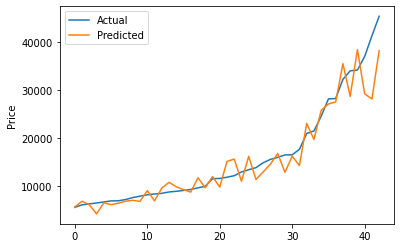

In [130]:
import matplotlib.pyplot as plt

plt.plot(predictionsPandasDF['price'],label="Actual")
plt.plot(predictionsPandasDF['prediction'],label="Predicted")

plt.ylabel('Price')
plt.legend()
plt.show()
# predictionsPandasDF.plot(kind='scatter',x='prediction',y='price')

# Hyper parameter tuning

In [131]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = ParamGridBuilder()\
                            .addGrid(lr.maxIter,[10,50,100])\
                            .addGrid(lr.regParam,[0.1,0.3,1.0])\
                            .addGrid(lr.elasticNetParam,[0.0,0.8,1.0])\
                            .build()

In [132]:
evaluator = RegressionEvaluator(
    labelCol='price',
    predictionCol='prediction',
    metricName='rmse'
)

In [133]:
from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [134]:
model = crossval.fit(trainingData)

In [136]:
lrModel = model.bestModel.stages[-1]
lrModel

LinearRegressionModel: uid=LinearRegression_0c13068c837e, numFeatures=43

In [138]:
print('maxIter=',lrModel._java_obj.getMaxIter())
print('elasticNetParam=',lrModel._java_obj.getElasticNetParam())
print('regParam=',lrModel._java_obj.getRegParam())


maxIter= 10
elasticNetParam= 1.0
regParam= 1.0


In [142]:
predictions = model.transform(testData)

In [143]:
evaluator = RegressionEvaluator(
    labelCol='price',
    predictionCol='prediction',
    metricName='r2'
)

rsquare = evaluator.evaluate(predictions)
print('Test R2 score of best model',rsquare)

Test R2 score of best model 0.9101524068530504


In [144]:
evaluator = RegressionEvaluator(
    labelCol='price',
    predictionCol='prediction',
    metricName='rmse'
)

rmse = evaluator.evaluate(predictions)
print('Test RMSE score of best model',rmse)

Test RMSE score of best model 3131.367857548252
